<a href="https://colab.research.google.com/github/DiwakarBasnet/Indigenous_language_translator/blob/main/indigenous_eng_m2m100_418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook setup

In [ ]:
!pip install transformers sentencepiece datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
# from transformers import AdamW

# from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import M2M100Tokenizer, AutoModelForSeq2SeqLM

from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

In [ ]:
# model_repo = 'google/mt5-small'
model_repo = 'facebook/m2m100_418M'

max_seq_len = 20  # model.config.max_length

## Steps:
1. Load pretrained model and tokenizer
2. Load the dataset
3. Transform the dataset into input
4. Train/finetune the model on our dataset
5. Test the model

## Load pretrained model and tokenizer

In [ ]:
# Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_repo)
tokenizer = M2M100Tokenizer.from_pretrained(model_repo)

In [ ]:
# Custom tokenizer test
# from transformers import RobertaTokenizerFast
# tokenizer = RobertaTokenizerFast.from_pretrained('newabert')

In [ ]:
# Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [ ]:
# Testing pretrained model and tokenizer

input_sen = '<new>This is a test sentence!'
# input_sen = '<en>जि ब्वनेकुथिं लिहां वयाः वसः हिलाबुला याये|'

tokenizer.src_lang = "ne"
token_ids = tokenizer.encode(input_sen, return_tensors='pt').cuda()  # Tokenization
print(tokenizer.convert_ids_to_tokens(token_ids[0]))

model_out = model.generate(token_ids, forced_bos_token_id=tokenizer.get_lang_id("ne"))  # Token input in model
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0])
)
print(output_text)

['__ne__', '<new>', '▁This', '▁is', '▁a', '▁test', '▁sent', 'ence', '!', '</s>']
tensor([[     2, 128066,  30761,   1618,  63447,  23441,   5819,  63447,  23441,
           1976,    371,      2]], device='cuda:0')
</s>__ne__ यहाँ एक परीक्षण वा परीक्षण हो ।</s>


## Load the dataset

In [ ]:
dataset = load_dataset("Unspoiled-Egg/indigenous-eng-translation")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2494
    })
})

In [ ]:
split_datasets = dataset['train'].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2244
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 250
    })
})

In [ ]:
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

In [ ]:
train_dataset['translation'][0]

{'en': 'i wear sewed clothes.',
 'mai': 'हम सिलल कपड़ा पहिरैत छी।',
 'new': 'जिं सुयाः ब्यूगु वस: पुना।'}

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'mai': '<mai>',
    'new': '<new>'
}

In [ ]:
# Adding special tokens to tokenizer vocab
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 128107. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(128107, 1024)

## Transform the dataset into input

In [ ]:
# Our input gets truncated to size 20
token_ids = tokenizer.encode(
    input_sen, return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len
)
print(token_ids)

tensor([[128066, 128106,  36606,    117,      8,   4183,   8931,   6226,     30,
              2,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1]])


In [ ]:
# Function to tokenize input and output

def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]
  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )

  return input_ids[0]


def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )

  return token_ids[0]


def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 for in  i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translation for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  # Encode our texts to their tokenzied patterns
  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map
  )
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map
  )

  return input_token_ids, target_token_ids


# Convert tokens to batch
def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len
    )
    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids


# Generator function
def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Checking above function (format_translation_data)
in_ids, out_ids = format_translation_data(
    train_dataset[1]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:',data_batch[0].shape)
print('Output shape:',data_batch[1].shape)

__ne__ <new> ▁घर क ▁बन ल ▁आ ▁घर ▁सं ▁बाहर ▁भेट य ▁वाला ▁खा द्य ▁पदार्थ क ▁मे ▁अंतर ▁करना य . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
__ne__ ▁छ े ँ य ् ▁द ये क ू गु ▁व ▁पि ने ▁द ये क ू गु ▁न सा ▁ब ्व थ ला द िस ँ । </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

## Train/finetune the model on our data

In [ ]:
# Parameters
n_epochs = 7
batch_size = 16
print_freq = 50
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps
)

In [ ]:
losses = []

In [ ]:
# Evaluation model
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch
    )
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
# Training and testing
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  # Loop through our batch data
  for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch
    )

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()

    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]
      ))

  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

<ipython-input-26-f4b540d517f1>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/141 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 1 | Step: 50 | Avg loss: 4.567 | lr: 0.000479038854805726
Epoch: 1 | Step: 100 | Avg loss: 2.988 | lr: 0.0004534764826175869
Test loss of 2.618


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg loss: 2.466 | lr: 0.00040695296523517383
Epoch: 2 | Step: 100 | Avg loss: 2.303 | lr: 0.00038139059304703477
Test loss of 2.443


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg loss: 1.974 | lr: 0.0003348670756646217
Epoch: 3 | Step: 100 | Avg loss: 1.936 | lr: 0.0003093047034764827
Test loss of 2.074


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg loss: 1.660 | lr: 0.00026278118609406953
Epoch: 4 | Step: 100 | Avg loss: 1.681 | lr: 0.00023721881390593048
Test loss of 1.917


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg loss: 1.339 | lr: 0.00019069529652351739
Epoch: 5 | Step: 100 | Avg loss: 1.326 | lr: 0.00016513292433537833
Test loss of 1.900


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg loss: 1.032 | lr: 0.00011860940695296524
Epoch: 6 | Step: 100 | Avg loss: 1.087 | lr: 9.304703476482618e-05
Test loss of 1.708


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg loss: 0.838 | lr: 4.652351738241309e-05
Epoch: 7 | Step: 100 | Avg loss: 0.842 | lr: 2.0961145194274028e-05
Test loss of 1.812


## Test model

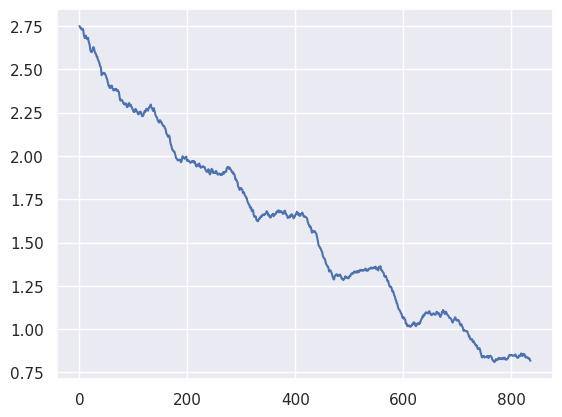

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

### Manual testing

In [ ]:
test_sentence = test_dataset[0]['translation']['new']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'en',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING
)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])
))

Raw input text: क्वय्‌या धलखय् च्वयादिसँ।
Truncated input text: __ne__<en>क्वय् या धलखय् च्वयादिसँ।</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

__ne__ write down in the table below.
__ne__ write down the table below.
__ne__ write down on the table below.


In [ ]:
test_dataset['translation'][0]

{'en': 'write in the following table.',
 'mai': 'निम्नलिखित तालिका में लिखे |',
 'new': 'क्वय्\u200cया धलखय् च्वयादिसँ।'}

In [ ]:
train_dataset['translation'][0]

{'en': 'i wear sewed clothes.',
 'mai': 'हम सिलल कपड़ा पहिरैत छी।',
 'new': 'जिं सुयाः ब्यूगु वस: पुना।'}

### Colab form

In [ ]:
#@title Translation cell
input_text = "we must not imitate bad things of others." #@param {type:"string"}
output_language = "mai" #@param ["new", "en", "mai"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING
)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + ' -> ' + \
        tokenizer.decode(output_tokens[0], skip_special_tokens=True))

we must not imitate bad things of others. -> __ne__ हमरा सभकेँ बाजबाक चाही।
